# Central dogma of molecular biology in our own cells

## Primary Authors:
- Go, Daphne Janelyn
- Gilo, Joshua
- Lasala, Kyle Carlo

## Notebook Version Control

In [ ]:
!pip install nbdime

In [ ]:
# Version Check
!nbdiff-web Bioinformatics_Ex1.ipynb https://raw.githubusercontent.com/KyleCarlo/gene-annotation-analysis-of-human-genome/refs/heads/main/Bioinformatics_Ex1.ipynb

^C


In [7]:
# Merging
!nbmerge-web Bioinformatics_Ex1.ipynb Bioinformatics_Ex1.ipynb https://raw.githubusercontent.com/KyleCarlo/gene-annotation-analysis-of-human-genome/refs/heads/main/Bioinformatics_Ex1.ipynb --out merged.ipynb

^C


## Prerequisites: Downloading the necessary data and importing the libraries.

In [ ]:
# gffutils for reading gtf
!pip install gffutils

In [2]:
import gffutils
import pandas as pd
import matplotlib.pyplot as plt

import urllib.request
import os
import gzip
import shutil

## Objective: 
1. Explore the human genome, transcriptome, and proteome.
2. Investigate specific, well-studied human genes by analyzing their genomic location, expression patterns, isoform diversity, and biological functions.

## Part 1. Human genome, transcriptome, proteome

There are multiple resources listed towards the bottom of this page, which provide information about the human genome. For example, you can download information about the human genome, transcriptome, and proteome from [RefSeq](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.40/) or from [GENCODE](https://www.gencodegenes.org/human/).

Using these resources, report on the following questions:

1. **How many genes are there in the human genome?**
2. **How many transcripts are there in the human transcriptome?**
3. **What are the different kinds/classes of RNA present in the human transcriptome?**
4. **How many protein-coding genes are there in the human genome?**
5. **How many proteins are there in the human proteome?**
6. **Plot the distribution of lengths of genes.**
7. **Plot the distribution of the length of exons.**
8. **Plot the distribution of the length of introns.**

In line with findings from Frankish et al. (2015), we compared and analyzed human gene annotations from both RefSeq and GENCODE, recognizing that while GENCODE offers broader transcript diversity and genomic coverage, RefSeq provides a more conservative and streamlined annotation set. The downloaded gene annotations is version ***Genome Reference Consortium Human Build 38 (GRCh38.p14)***

We specifically downloaded the [Comprehensive gene annotation (CHR) from GENCODE (GTF)](https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_48/gencode.v48.annotation.gtf.gz), which includes the full set of gene annotations mapped to the reference chromosomes only. Additionally, we downloaded the <span style="color:#ADD8E6;">gene annotation feature (GTF) source files from both RefSeq and GenBank</span> for comparison. See the image below.

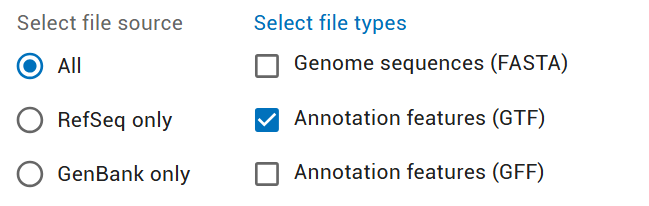

Frankish, A., Uszczynska, B., Ritchie, G.R. et al. Comparison of GENCODE and RefSeq gene annotation and the impact of reference geneset on variant effect prediction. BMC Genomics 16 (Suppl 8), S2 (2015). https://doi.org/10.1186/1471-2164-16-S8-S2

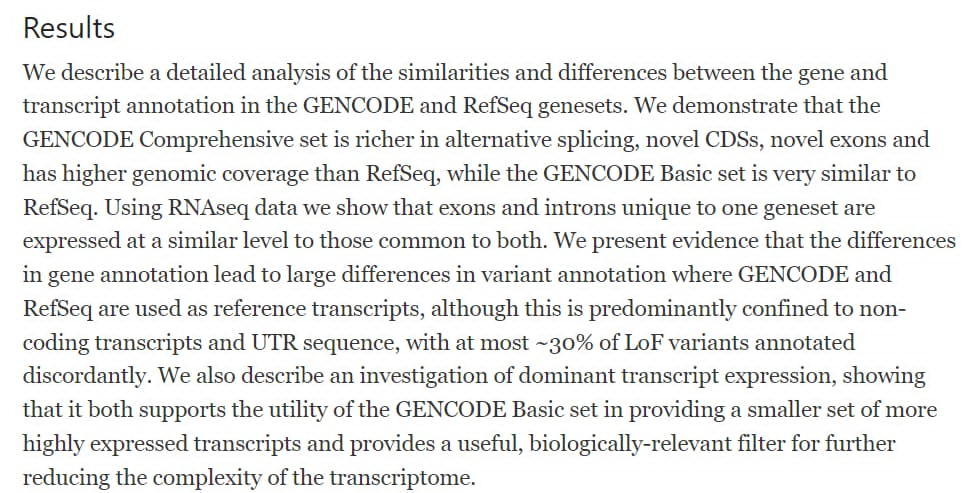

In [4]:
urls = {
    "gencode.v48.annotation.gtf.gz":
        "ftp://ftp.ebi.ac.uk/pub/databases/gencode/"
        "Gencode_human/release_48/gencode.v48.annotation.gtf.gz",

    "GCF_000001405.40_GRCh38.p14_genomic.gtf.gz":
        "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/"
        "GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_genomic.gtf.gz"
}

for filename, url in urls.items():
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download.")
    else:
        print(f"Downloading {filename} ...")
        urllib.request.urlretrieve(url, filename)
        print(f"Saved to {filename}")

for fn in urls:
    out_fn = fn[:-3]
    if os.path.exists(out_fn):
        print(f"{out_fn} already exists, skipping decompression.")
    else:
        print(f"Decompressing {fn} to {out_fn} ...")
        with gzip.open(fn, 'rb') as f_in, open(out_fn, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed to {out_fn}")
        os.remove(fn)

Saved to gencode.v48.annotation.gtf.gz
Saved to GCF_000001405.40_GRCh38.p14_genomic.gtf.gz
gencode.v48.annotation.gtf already exists, skipping decompression.
GCF_000001405.40_GRCh38.p14_genomic.gtf already exists, skipping decompression.


### Creating a DB for GTF files

These creates a database for both datasets, you only run this once. Once you have the `.db` files, you can now use it to query data.

In [ ]:
gencode_file = 'gencode.v48.annotation.gtf'
db_file = 'gencode.db'
gencode_db = gffutils.create_db(gencode_file, dbfn=db_file, disable_infer_genes=True, disable_infer_transcripts=True, force=True, keep_order=True, merge_strategy='merge', sort_attribute_values=True)

In [5]:
refseq_file = 'GCF_000001405.40_GRCh38.p14_genomic.gtf'
db_file = 'refseq.db'
refseq_db = gffutils.create_db(refseq_file, dbfn=db_file, disable_infer_genes=True, disable_infer_transcripts=True, force=True, keep_order=True, merge_strategy='merge', sort_attribute_values=True)

### Reading GTF DB

Run these cells to read the generated `.db` files.

In [4]:
db_file = 'gencode.db'
gencode = gffutils.FeatureDB(db_file)

In [5]:
db_file = 'refseq.db'
refseq = gffutils.FeatureDB(db_file)

### How many genes are there in the human genome?

#### Data Source: GENCODE

In [34]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT id) FROM features
    WHERE featuretype='gene';
""")

cursor.fetchall()[0][0]

78686

To count the number of genes in the dataset, we filtered the rows where the `featuretype` is `"gene"` and counted the distinct number of rows from the column `id`. According to the [GENCODE release statistics](https://www.gencodegenes.org/human/stats_48.html) for this gene annotation, there are **78,686 genes**, which matches the number we obtained from our analysis. 

##### Without Pseudogenes

In [108]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT id) FROM features
    WHERE json_extract(attributes, '$.gene_type') NOT LIKE '%pseudogene%'
    AND featuretype='gene'
""")

cursor.fetchall()[0][0]

63494

We filtered out pseudogenes by removing rows and adding a condition where the `gene_type` contains the substring `"pseudogene"` and counted the distinct number of rows from the column `id`. According to the [GENCODE release statistics](https://www.gencodegenes.org/human/stats_48.html), there are 14,695 pseudogenes, and subtracting this from the total gene count (78,686) yields 63,991 genes, which is already close to our analysis. We got **63,494 genes exclusding pseudogenes**.

#### Data Source: RefSeq

In [6]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.gene')) FROM features;
""")

refseq_gene_count = cursor.fetchall()[0][0]
print(refseq_gene_count)

59701


To count the number of genes in the dataset, we just counted the number of distinct elements in the `gene`. According to the [annotation report from NCBI](https://www.ncbi.nlm.nih.gov/refseq/annotation_euk/Homo_sapiens/GCF_000001405.40-RS_2024_08/), there are 59,715 genes. This closely matches our results, where we identified **59,701 genes**.

##### Without pseudogenes

In [8]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.gene')) FROM features
    WHERE json_extract(attributes, '$.pseudo')='["true"]';
""")

print(refseq_gene_count - cursor.fetchall()[0][0])

42622


We added a condition to filter out pseudogenes by counting the number of rows where `pseudo` is tagged as `true` and then subtracted it to the original gene count. According to the [annotation report from NCBI](https://www.ncbi.nlm.nih.gov/refseq/annotation_euk/Homo_sapiens/GCF_000001405.40-RS_2024_08/), there are 42,257 genes. This closely matches our results, where we identified **42,622 genes excluding pseudogenes**.

### How many transcripts are there in the human transcriptome?

#### Data Source: GENCODE

In [22]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT id) FROM features 
    WHERE featuretype='transcript';
""")

cursor.fetchall()[0][0]

385669

To count the number of transcripts, we filtered out the rows where the `featuretype` is `"transcript"` and counted the distinct number of rows from the column `id`. According to the [GENCODE release statistics](https://www.gencodegenes.org/human/stats_48.html) for this gene annotation, there are **385,669 transcripts**, which matches the number we obtained from our results.

#### Data Source: RefSeq (NCBI)

In [23]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT id) FROM features 
    WHERE featuretype='transcript';
""")

cursor.fetchall()[0][0]

201189

Similar to GENCODE, we filtered out the rows where the `featuretype` is `"transcript"` and then counted the number of distinct ids. According to the [annotation report from NCBI](https://www.ncbi.nlm.nih.gov/refseq/annotation_euk/Homo_sapiens/GCF_000001405.40-RS_2024_08/), there are 185,558	transcripts. This is slightly deviated with our results, where we identified **201,189 transcripts**.

### What are the different kinds/classes of RNA present in the human transcriptome?

#### Data Source: GENCODE

In [30]:
cursor = gencode.conn.execute("""
    SELECT DISTINCT json_extract(attributes, '$.gene_type') FROM features
    WHERE json_extract(attributes, '$.gene_type') LIKE '%RNA%'
""")

for each in cursor.fetchall():
    for each_2 in each:
        print(each_2)

["lncRNA"]
["miRNA"]
["snRNA"]
["misc_RNA"]
["snoRNA"]
["scaRNA"]
["rRNA_pseudogene"]
["rRNA"]
["sRNA"]
["vault_RNA"]
["Mt_tRNA"]
["Mt_rRNA"]


To get the types of RNA, we filtered out the rows that only includes the substring `"RNA"` from the `gene_type` feature and displayed the distinct elements from the same feature. According to the [GENCODE release statistics](https://www.gencodegenes.org/human/stats_48.html), the RNA types are **lncRNA, miRNA, misc_RNA, Mt_rRNA, Mt_tRNA, rRNA, rRNA_pseudogene, scaRNA, snoRNA, snRNA, sRNA, vault_RNA**, which matches our results.

#### Data Source: RefSeq (NCBI)

In [33]:
cursor = refseq.conn.execute("""
    SELECT DISTINCT json_extract(attributes, '$.transcript_biotype') FROM features
    WHERE json_extract(attributes, '$.transcript_biotype') LIKE '%RNA%'
""")

for each in cursor.fetchall():
    for each_2 in each:
        print(each_2)

["miRNA"]
["lnc_RNA"]
["mRNA"]
["snRNA"]
["snoRNA"]
["ncRNA"]
["antisense_RNA"]
["tRNA"]
["rRNA"]
["telomerase_RNA"]
["vault_RNA"]
["Y_RNA"]
["RNase_MRP_RNA"]
["scRNA"]
["RNase_P_RNA"]


To get the types of RNA, we filtered out the rows that only includes the substring `"RNA"` from the `transcript_biotype` feature and displayed the distinct elements from the same feature. According to the [annotation report from NCBI](https://www.ncbi.nlm.nih.gov/refseq/annotation_euk/Homo_sapiens/GCF_000001405.40-RS_2024_08/), the RNA types are **mRNA, misc_RNA, miRNA, tRNA, lncRNA, snoRNA, snRNA, antisense_RNA, rRNA, vault_RNA, telomerase_RNA, RNase_MRP_RNA, RNase_P_RNA, Y_RNA, scRNA**, which matches the result of our query.

### How many protein-coding genes are there in the human genome?

#### Data Source: GENCODE

In [42]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.gene_id')) FROM features 
    WHERE json_extract(attributes, '$.gene_type')='["protein_coding"]'
    AND json_extract(attributes, '$.tag') NOT LIKE '%read%';
""")

cursor.fetchall()[0][0]

19452

To get the number of protein-coding genes, we filtered out the `gene_type` into `"protein_coding"` only and filtered out the `tag` does not contain the substring `"read"`. Then we counted the number of distinct elements in the `gene_id` column. According to the [GENCODE release statistics](https://www.gencodegenes.org/human/stats_48.html), there are **19435** protein-coding genes, which exactly matches our result.

#### Data Source: RefSeq (NCBI)

In [47]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.gene')) FROM features 
    WHERE json_extract(attributes, '$.gene_biotype')='["protein_coding"]'
""")

cursor.fetchall()[0][0]

20078

To get the number of protein-coding genes, we filtered out the `gene_biotype` into `"protein-coding"` only and counted the number of distinct elements in the `gene` column. According to the [annotation report from NCBI](https://www.ncbi.nlm.nih.gov/refseq/annotation_euk/Homo_sapiens/GCF_000001405.40-RS_2024_08/), there are **20,078 protein-coding genes**, which matches exactly our result.

### How many proteins are there in the human proteome?

#### Data Source: GENCODE

In [50]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.protein_id')) FROM features;
""")

cursor.fetchall()[0][0]

112346

To get the number of proteins, we counted all the distinct elements from the `protein_id` column. The GENCODE statistics did not include this from the report, but our query results into **112,346 proteins**.

#### Data Source: RefSeq (NCBI)

In [51]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.protein_id')) FROM features;
""")

cursor.fetchall()[0][0]

136282

Similar to GENCODE, we counted all distinct elements from the `protein_id` column. The annotation report of NCBI did not include this from the report, but our query results into **136,282 proteins**.

### Plot the distribution of lengths of genes.

#### Data Source: GENCODE

In this part, we constructed a SQL query to extract relevant information from the GENCODE SQLite database. Specifically, we selected the `featuretype`, a cleaned version of the `transcript_id`, and the `start` and `end` genomic coordinates from the `features` table. We then loaded the result of the query into a pandas DataFrame named `gencode_df` using `pd.read_sql`. We renamed the columns to `type`, `transcript_id`, `start`, and `end` for clarity. Finally, we added a new column called `length`, which calculates the length of each transcript (or feature) by subtracting the `start` position from the `end` position. This allowed us to compute the genomic feature lengths for further analysis, such as plotting the distribution of transcript lengths.

In [6]:
query = """
    SELECT featuretype, SUBSTRING(json_extract(attributes, '$.transcript_id'), 3, LENGTH(json_extract(attributes, '$.transcript_id'))-4), 
    start, end FROM features;
"""
gencode_df = pd.read_sql(query, gencode.conn)
gencode_df.columns = ['type', 'transcript_id', 'start', 'end']
gencode_df['length'] = gencode_df['end'] - gencode_df['start']

In [7]:
gencode_df[gencode_df["type"]=="gene"][['start', 'end', 'length']].describe()

,start,end,length
count,7.868600e+04,7.868600e+04,7.868600e+04
mean,7.474854e+07,7.477998e+07,3.143851e+04
std,5.588770e+07,5.589030e+07,8.614636e+04
min,5.770000e+02,6.470000e+02,7.000000e+00
25%,3.038022e+07,3.040348e+07,7.610000e+02
50%,6.218170e+07,6.220718e+07,4.596000e+03
75%,1.104158e+08,1.104551e+08,2.596550e+04
max,2.489366e+08,2.489371e+08,2.473538e+06


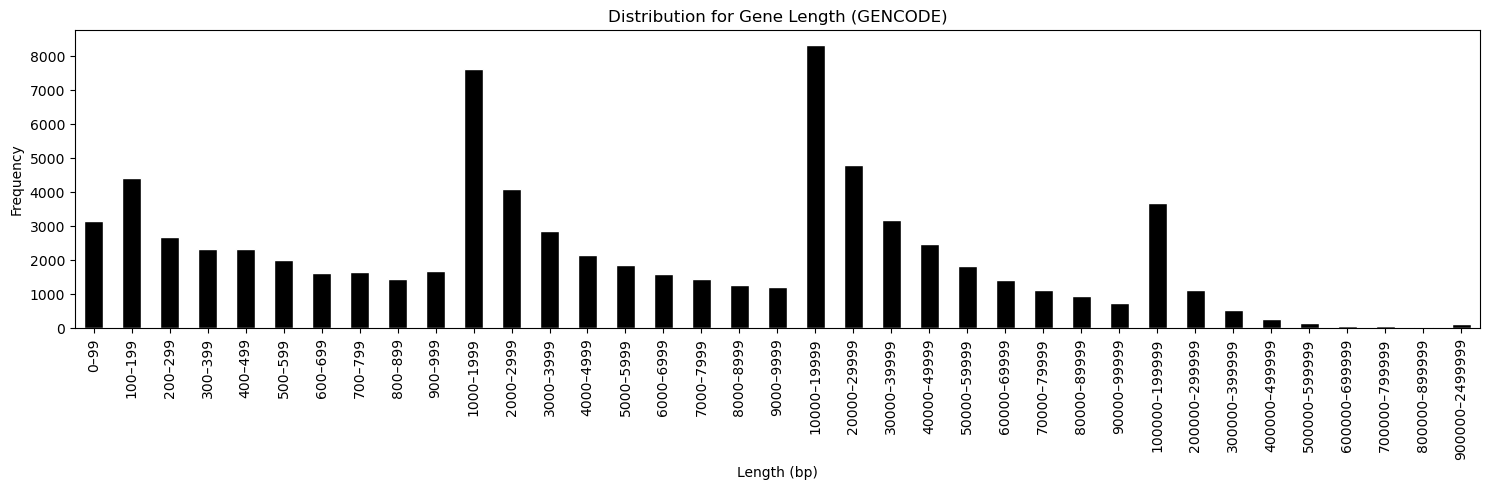

In [8]:
gene_lengths = gencode_df[gencode_df['type'] == 'gene']['length']

bin_edges = (
    list(range(0, 1000, 100)) +
    list(range(1000, 10000, 1000)) +
    list(range(10000, 100000, 10000)) +
    list(range(100000, 1000000, 100000)) +
    [2500000]
)
bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

binned = pd.cut(gene_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Gene Length (GENCODE)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
min(gene_lengths), max(gene_lengths)

(7, 2473538)

As per the analysis, the shortest gene length is 7 bp while the longest is 2,473,538 bp. We also observed that **some genes are relatively short**, with a large number falling within the 0–1999 base pair (bp) range. There are **distinct peaks in the 100–199 bp and 1000–1999 bp bins**, suggesting that short genes are highly prevalent. Interestingly, there is also a **strong spike in the 10,000–19,999 bp range**, indicating a substantial number of moderately long genes. While the frequency of genes generally decreases with increasing length, the **distribution exhibits a heavy right tail extending up to 2.5 million bp**, representing a small subset of very long genes. This wide variation in gene length likely reflects the complexity of gene structure, where some genes contain numerous introns or regulatory elements, while others are more compact. Overall, the distribution appears somewhat bimodal, with one mode in the short gene region and another around 10–20 kb, followed by a gradual decline, illustrating the diverse architecture of human genes.

#### Data Source: RefSeq (NCBI)

The logic is almost the same with the GENCODE database. We start by defining a SQL query to select specific information from the `features` table: the feature type, a cleaned-up version of the `transcript_id` extracted from a JSON field called `attributes`, and the start and end coordinates of each feature. Then, we execute this query using pandas’ `read_sql` function to load the data into a DataFrame named `refseq_df`. After loading, we rename the columns to more intuitive names — `type`, `transcript_id`, `start`, and `end`. Finally, we add a new column `length` by calculating the difference between the `end` and `start` positions, giving us the length of each feature. 

In [10]:
query = """
    SELECT featuretype, SUBSTRING(json_extract(attributes, '$.transcript_id'), 3, LENGTH(json_extract(attributes, '$.transcript_id'))-4), start, end FROM features;
"""
refseq_df = pd.read_sql(query, refseq.conn)
refseq_df.columns = ['type', 'transcript_id', 'start', 'end']
refseq_df['length'] = refseq_df['end'] - refseq_df['start']

In [11]:
refseq_df[refseq_df['type'] == 'gene'][['start', 'end', 'length']].describe()

,start,end,length
count,6.742900e+04,6.742900e+04,6.742900e+04
mean,6.600083e+07,6.602978e+07,2.894632e+04
std,5.792598e+07,5.793032e+07,8.293749e+04
min,1.000000e+00,1.070000e+02,7.000000e+00
25%,1.834998e+07,1.837848e+07,8.990000e+02
50%,5.159851e+07,5.162277e+07,5.292000e+03
75%,1.029000e+08,1.029508e+08,2.268400e+04
max,2.489366e+08,2.489371e+08,2.473619e+06


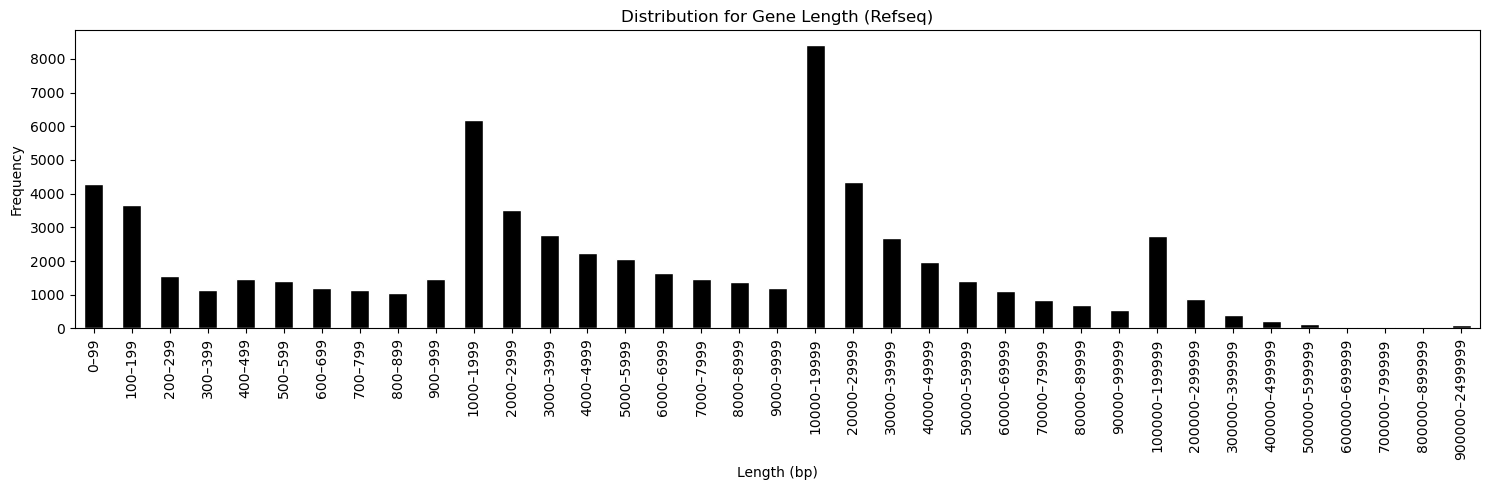

In [12]:
gene_lengths = refseq_df[refseq_df['type'] == 'gene']['length']
bin_edges = (
    list(range(0, 1000, 100)) +
    list(range(1000, 10000, 1000)) +
    list(range(10000, 100000, 10000)) +
    list(range(100000, 1000000, 100000)) +
    [2500000]
)
bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

binned = pd.cut(gene_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Gene Length (Refseq)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
min(gene_lengths), max(gene_lengths)

(7, 2473619)

As per the analysis, the shortest gene length is 7 bp while the longest is 2,473,619 bp. There are **some genes that are relatively short**, with a high frequency of genes falling within the initial bins. Specifically, there is a large number of genes in the 0-99 bp range, indicating a significant presence of very short genes. Following this, there are distinct peaks in the 1000–1999 bp bin, suggesting a **strong prevalence of short to medium-length genes**. Interestingly, there is also a strong spike, representing the most dominant peak, in the 10,000–19,999 bp range, indicating a substantial number of **moderately long genes**. While the frequency of genes generally decreases with increasing length beyond this point, the distribution exhibits a **heavy right tail extending to much longer lengths**, representing a smaller subset of very long genes, including a noticeable peak around 100,000–199,999 bp. This wide variation in gene length likely reflects the diverse functional and structural requirements of genes. Overall, the distribution appears to be multi-modal, with prominent modes in the very short (0-99 bp), short-to-medium (1000-1999 bp), and moderately long (10,000-19,999 bp) gene regions, followed by a gradual decline, illustrating the varied architecture of genes in the RefSeq database.

#### Comparison between GENCODE and Refseq gene length distribution

The distributions of gene length from GENCODE and RefSeq are **similar to each other**. Both graphs are multimodal and show frequency peaks at 1,000–1,999 bp, 10,000–19,999 bp, and 100,000–199,999 bp. Overall, the distributions are right-skewed, exhibiting a heavy tail.

### Plot the distribution of the length of exons.

We used the previously generated dataframes, `gencode_df` for GENCODE and `refseq_df` for Refseq and selected all rows where all `type` is `"exon"`. We are only interested in the column `length` that shows the length of a particular exon.

#### Data Source: GENCODE

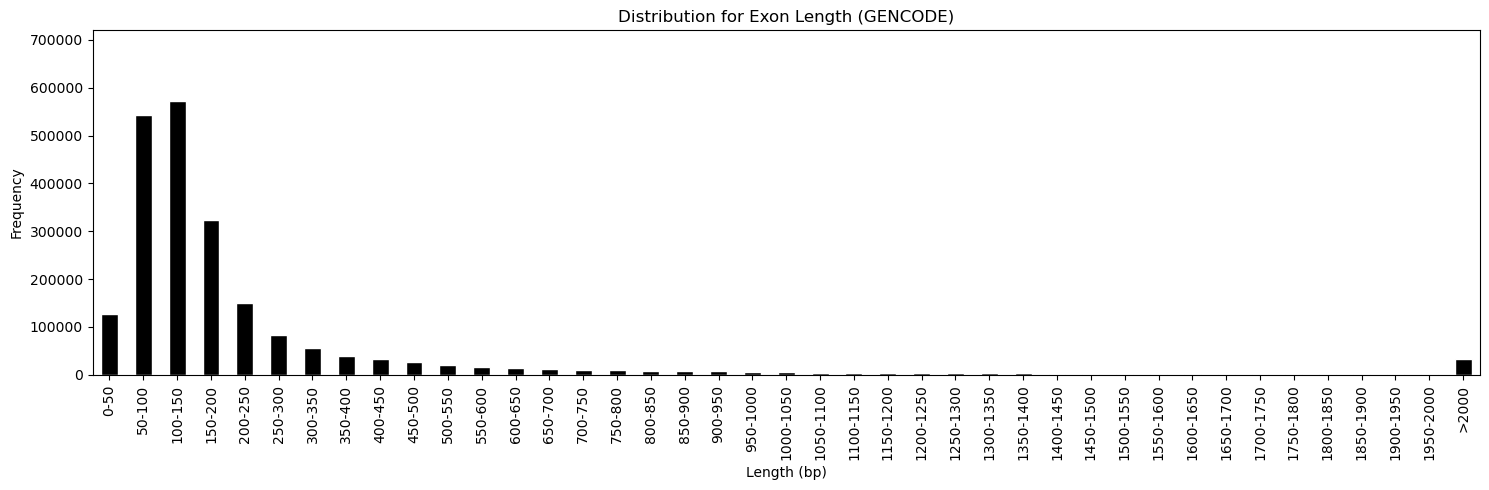

In [31]:
exon_lengths = gencode_df[gencode_df['type'] == 'exon']['length']

bin_edges = list(range(0, 2001, 50)) + [10000]
bin_labels = [f"{i}-{i+50}" for i in range(0, 2000, 50)] + ['>2000']
binned = pd.cut(exon_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Exon Length (GENCODE)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylim(0, 720_000)
plt.show()

In [15]:
min(exon_lengths), max(exon_lengths)

(0, 347299)

The exon length distribution based on GENCODE, is heavily skewed to the right with a heavy tail end. It has a minimum length of 0 bp and maximum length of 347,299 bp. The vast **majority of exons are short**, with the highest frequencies observed in the 50-100 bp bin (approaching 600,000 exons), followed closely by the 0-50 bp and 100-150 bp categories. Frequencies decline steeply as exon length increases, although a **notable number of exons persist in much longer length categories**, extending to over 2000 bp. This indicates that while short exons are overwhelmingly more common, longer exons do exist, albeit in significantly smaller quantities.

#### Data Source: RefSeq (NCBI)

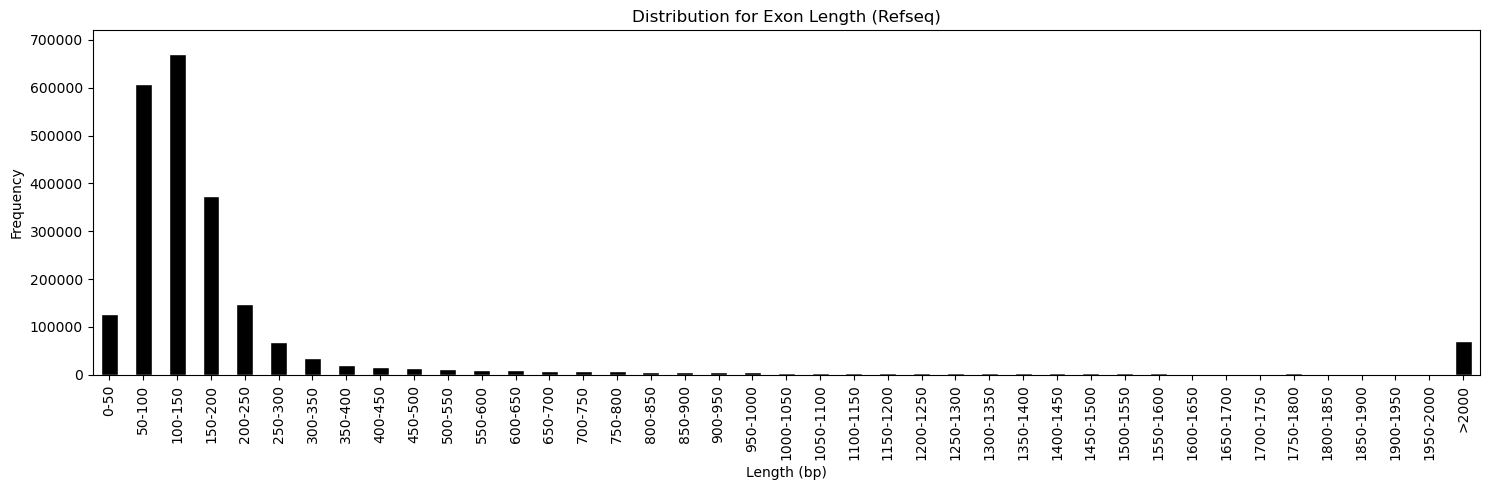

In [32]:
exon_lengths = refseq_df[refseq_df['type'] == 'exon']['length']

bin_edges = list(range(0, 2001, 50)) + [10000]
bin_labels = [f"{i}-{i+50}" for i in range(0, 2000, 50)] + ['>2000']
binned = pd.cut(exon_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Exon Length (Refseq)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylim(0, 720_000)
plt.show()

In [17]:
min(exon_lengths), max(exon_lengths)

(0, 91666)

The exon length distribution based on Refseq is heavily skewed to the right, signifying that the vast majority of exons are relatively short. The highest frequencies are concentrated in the shortest length categories: the 50-100 bp bin shows the highest frequency, approaching 700,000 exons, followed by the 0-50 bp and 100-150 bp bins, both well over 300,000. As exon length increases beyond these initial bins, the frequency drops off rapidly, forming a long and attenuated tail. Despite the sharp decrease in frequency for longer lengths, a notable number of exons are still observed in the very long categories, including the >2000 bp bin, which contains approximately 70,000 exons. This pattern clearly demonstrates that while short exons are overwhelmingly more common, longer exons do exist, though in significantly smaller quantities.

#### Comparison between GENCODE and Refseq exon length distribution

The distributions of exon length from GENCODE and RefSeq are **similar to each other**. A subtle difference can be seen in the peaks. GENCODE's highest peak is approximately 600,000 while Refseq's peak is approximately 700,000. Both follows a unimodal pattern and have the same peak at 50-150 bp. Using the same binning, both distributions closely follows the same distribution reported by Sakharkar et. al (2005). However, based on the distribution of Sakharkar et. al, the peaks is approximately 75,000 which is significantly lower compared to GENCODE and Refseq.

This discrepancy in frequency might be caused by different annotation versions. Sakharkar et al. used genome annotations that were available in the early 2000s, when both GENCODE and RefSeq had fewer annotated genes and transcripts. Our uses modern annotations, which are far more comprehensive, with many more transcripts and alternative splicing events included. This results into higher number of exons, higher counts per bin, even if the shape remains the same.

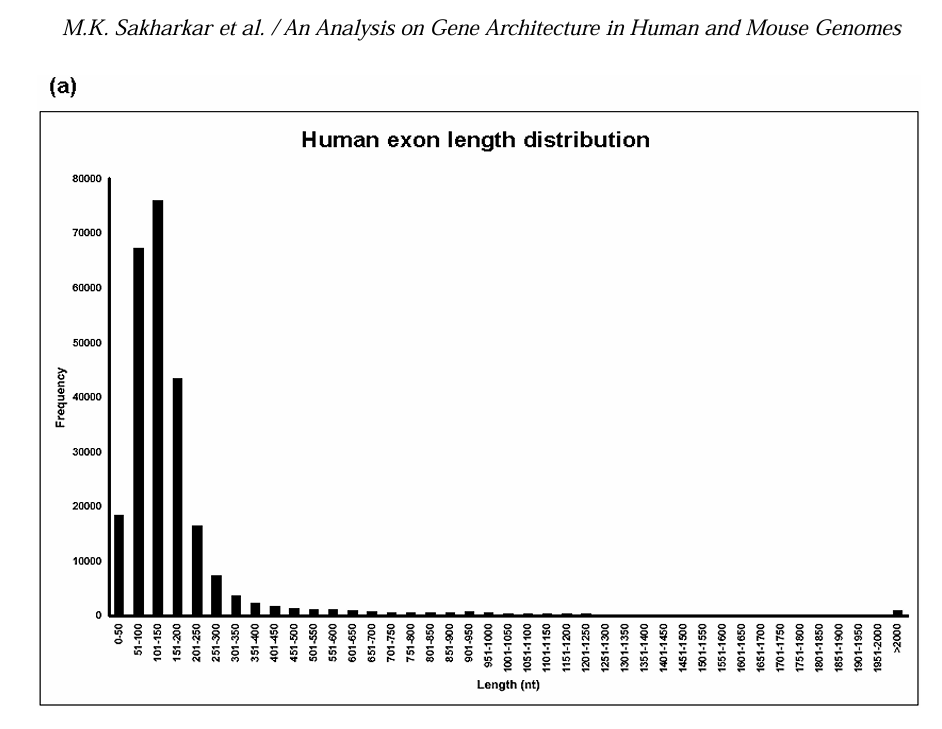

Sakharkar, M., Perumal, B., Sakharkar, K., & Kangueane, P. (2005). An analysis on gene architecture in human and mouse genomes. In Silico Biology, 5, 347–365. https://doi.org/10.3233/ISB-00192

### Plot the distribution of the length of introns.

To get the intron lengths, we have to filter first our data where `type` is `"exon"` to get all the exons with coordinates `start` and `end`. Next, we grouped them according to `transcript_id` and sorted according to `transcript_id` and `start`. Since the exons are grouped according to its corresponding transcript and already sorted, we use the exon coordinates `start` and `end` to infer the intron length. We subtract each element in the `start` at index *i+1* to the element in the `end` at index *i*.  

$$ intron[i] = start[i+1] - end[i] $$

#### Data Source: GENCODE

In [18]:
gencode_introns_df = gencode_df[gencode_df['type'] == 'exon'].reset_index().drop('index', axis=1)[['transcript_id', 'start', 'end']]
gencode_introns_df = gencode_introns_df.sort_values(['transcript_id', 'start']).reset_index().drop('index', axis=1)
gencode_introns_df = gencode_introns_df.groupby('transcript_id').agg(list)

In [19]:
introns = []
i = 0
for each in gencode_introns_df.itertuples():
    _, start, end = each
    start = pd.Series(start + [0])
    end = pd.Series([0] + end)
    introns += list(start-end)[1:-1]

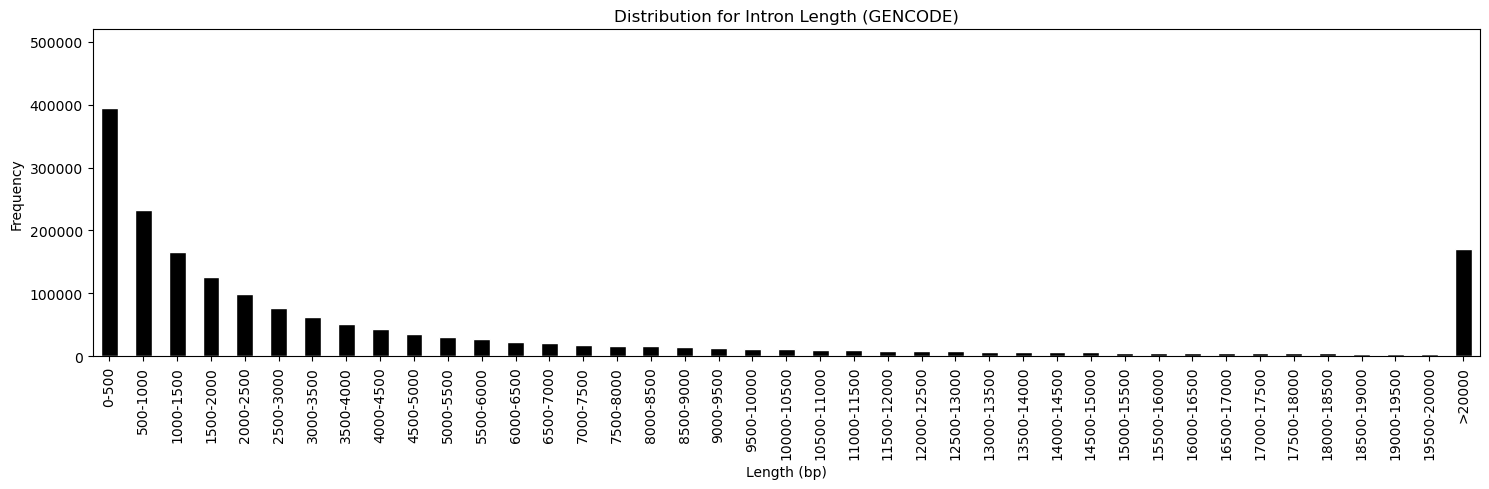

In [26]:
intron_lengths = pd.Series(introns)

bin_edges = list(range(0, 20001, 500)) + [2_000_000]
bin_labels = [f"{i}-{i+500}" for i in range(0, 20000, 500)] + ['>20000']
binned = pd.cut(intron_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Intron Length (GENCODE)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylim(0,520_000)
plt.show()

In [21]:
min(intron_lengths), max(intron_lengths)

(2, 1240121)

The intron length distribution of GENCODE is highly skewed to the right, indicating a **strong prevalence of shorter introns**. The 0-500 bp bin has the highest frequency, approaching 400,000 introns. There's a rapid decrease in frequency as intron length increases, with subsequent bins like 500-1000 bp and 1000-1500 bp showing considerably lower, though still substantial, frequencies.

Despite the sharp decline, the distribution exhibits a very long and heavy tail, extending to exceptionally long intron lengths. Notably, the >20000 bp bin still contains a significant number of introns, with a frequency exceeding 150,000. This indicates that while the vast majority of introns are relatively short, a substantial population of very long introns also exists within the Refseq annotation.

**Note that the binning of values is per 500 bp**. This means that compared to the exon length distributions, introns are longer.

#### Data Source: RefSeq (NCBI)

In [28]:
refseq_introns_df = refseq_df[refseq_df['type'] == 'exon'].reset_index().drop('index', axis=1)[['transcript_id', 'start', 'end']]
refseq_introns_df = refseq_introns_df.sort_values(['transcript_id', 'start']).reset_index().drop('index', axis=1)
refseq_introns_df = refseq_introns_df.groupby('transcript_id').agg(list)

In [29]:
introns = []
i = 0
for each in refseq_introns_df.itertuples():
    _, start, end = each
    start = pd.Series(start + [0])
    end = pd.Series([0] + end)
    introns += list(start-end)[1:-1]

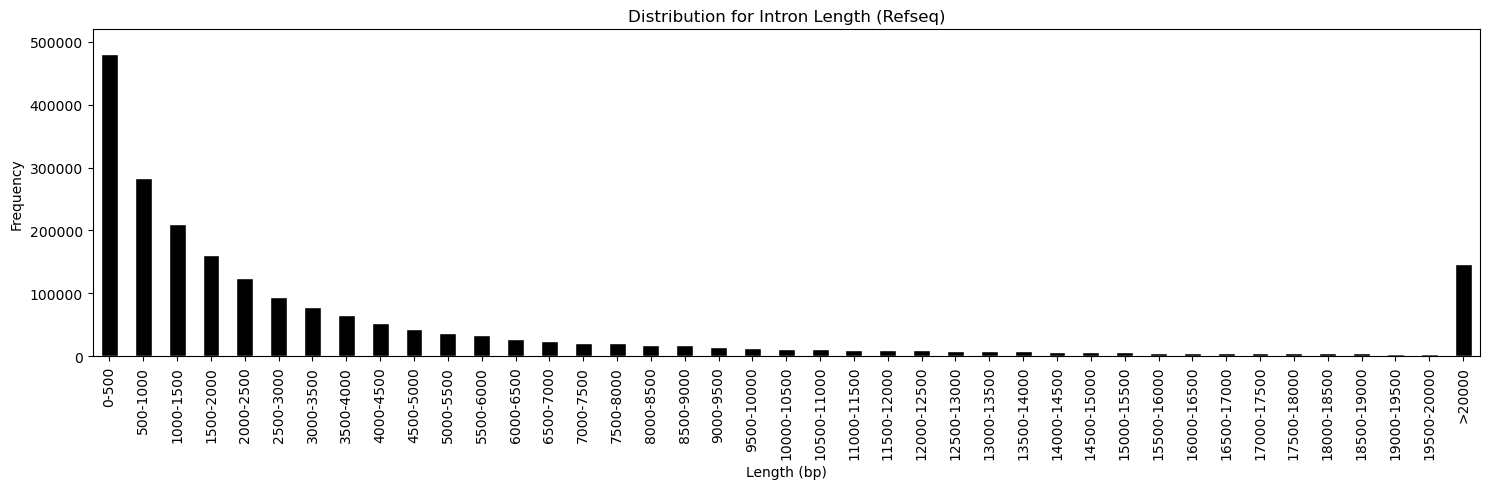

In [30]:
intron_lengths = pd.Series(introns)

bin_edges = list(range(0, 20001, 500)) + [2_000_000]
bin_labels = [f"{i}-{i+500}" for i in range(0, 20000, 500)] + ['>20000']
binned = pd.cut(intron_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Intron Length (Refseq)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylim(0,520_000)
plt.show()

In [24]:
min(intron_lengths), max(intron_lengths)

(2, 1160412)

The intron length distribution of Refseq is overwhelmingly skewed to the right, signifying that the vast majority of introns are relatively short. The 0-500 bp bin shows the highest frequency, with almost 500,000 introns. Following this, the frequency rapidly decreases as intron length increases. For example, the 500-1000 bp bin has a frequency below 300,000, and subsequent bins show a continuous decline.

Despite the sharp initial drop, the distribution exhibits a very long and heavy tail, extending to exceptionally long intron lengths. Notably, even though the frequencies are very low for most of the longer bins, there's a significant resurgence in the final >20000 bp bin, which contains a substantial number of introns, exceeding 100,000.

**Similar to GENCODE, the binning of values is per 500 bp.** This means that introns are longer than exons

#### Comparison between GENCODE and Refseq intron length distribution

The distributions of intron length from GENCODE and Refseq are **similar to each other**. A subtle difference can be seen in the peaks. GENCODE's highest peak is approximately 450,000 while Refseq's peak is approximately 500,000. Both follows a unimodal pattern and have the same peak at 0-500 bp. Comparing these distributions to Sakharhar et. al (2005), the skewness and tails are the same although different binning of values are shown. The distribution of Sakharhar et. al is also significantly lower compared to the GENCODE and Refseq with probably the same case to the exon distribution.

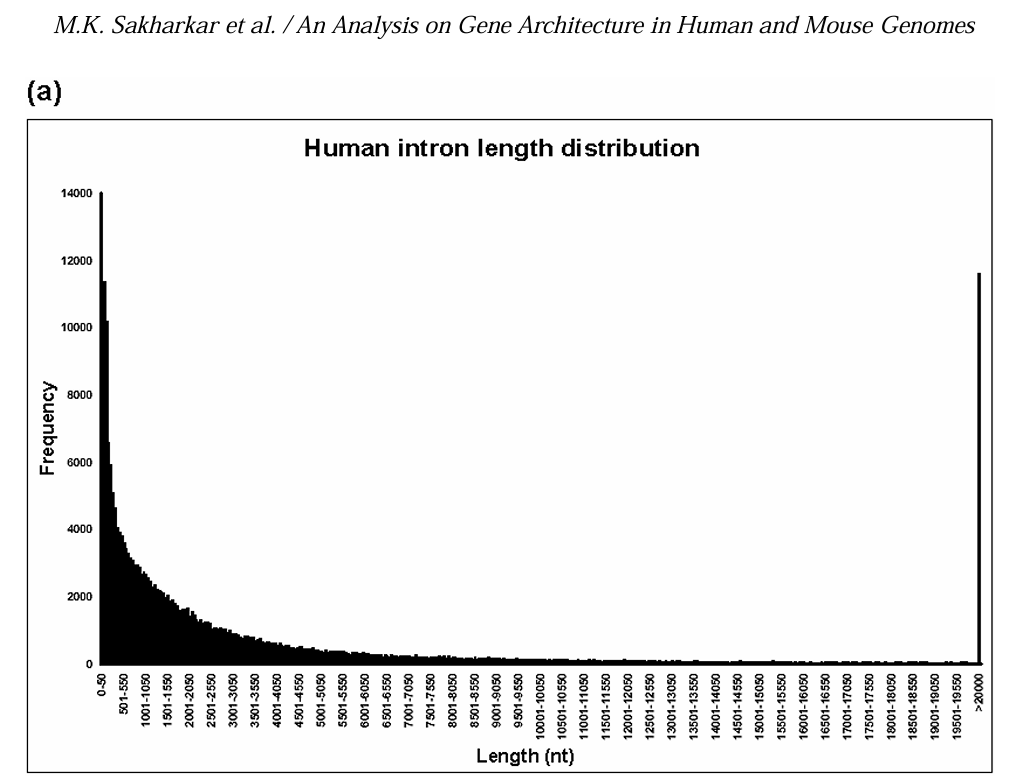

Relative to the exon length distribution, **introns are considered longer compared to exons**. There are several reasons why introns are longer. According to Jo and Choi (2015), exons, which contain the protein-coding sequences, are often relatively short and conserved across species while introns, on the other hand, can vary greatly in length and may contain sequences that regulate gene expression or splicing.

Jo, B. S., & Choi, S. S. (2015). Introns: The Functional Benefits of Introns in Genomes. Genomics & informatics, 13(4), 112–118. https://doi.org/10.5808/GI.2015.13.4.112

## Part 2. Greatest hits of the human genome

Although maybe a bit outdated, **[Dolgin, 2017]** compiled a list of the top 10 most studied genes in the human genome. Choose 3 out of the 10; and for each gene, answer the following questions:

1. **Where is it located in the genome, based on hg38 reference genome coordinates?**
2. **In which human tissues is the gene known to be expressed?**
3. **How many gene isoforms (alternatively spliced mRNAs) are known for each gene?**
4. **What is the average length of exons and average length of introns, across all isoforms?**
5. **How many protein isoforms are known for each gene?**
6. **What functions of the genes/proteins are known?**

Elie Dolgin. The most popular genes in the human genome. Nature, 551(7681):427–431, November 2017.

For this part, we referred to the RefSeq human genome annotation instead of GENCODE because NCBI provides more structured information about genes, making it easier to cross-check specific details.

### Selected Genes
1. **TP53**
2. **TNF**
3. **EGFR**

### Where is it located in the genome, based on hg38 reference genome coordinates?

To get the coordinates of the selected genes (**TP53, TNF, EGFR**), we select the rows that has a `gene` feature equal to `"TP53"` or `"TNF"` or `"EGFR"`. Then, we extract the necessary information for each rows i.e. `gene_id`, `gene`, `transcript_id`, `featuretype`, `start`, and `end`. Finally, the `pd.read_sql()` function executes this query and loads the resulting data into a Pandas DataFrame called `genome_3_df` for further analysis.

In [6]:
query = """
    SELECT seqid, SUBSTRING(json_extract(attributes, '$.gene_id'), 3, LENGTH(json_extract(attributes, '$.gene_id'))-4) as gene_id, 
    SUBSTRING(json_extract(attributes, '$.gene'), 3, LENGTH(json_extract(attributes, '$.gene'))-4) as gene,
    json_extract(attributes, '$.transcript_id') as transcript_id, featuretype as type, start, end FROM features
    WHERE json_extract(attributes, '$.gene')='["TP53"]'
    OR json_extract(attributes, '$.gene')='["TNF"]'
    OR json_extract(attributes, '$.gene')='["EGFR"]'
"""
genome_3_df = pd.read_sql(query, refseq.conn)

TP53 location

In [8]:
tp53_df = genome_3_df[(genome_3_df['type'] == 'transcript') & (genome_3_df['gene'] == 'TP53')]
tp53_df

,seqid,gene_id,gene,transcript_id,type,start,end
556,NC_000017.11,TP53,TP53,"[""NR_176326.1""]",transcript,7668421,7687490
567,NC_000017.11,TP53,TP53,"[""NM_001276761.3""]",transcript,7668421,7687490
589,NC_000017.11,TP53,TP53,"[""NM_001126112.3""]",transcript,7668421,7687490
613,NC_000017.11,TP53,TP53,"[""NM_001407269.1""]",transcript,7668421,7687490
635,NC_000017.11,TP53,TP53,"[""NM_001407268.1""]",transcript,7668421,7687490
659,NC_000017.11,TP53,TP53,"[""NM_000546.6""]",transcript,7668421,7687490
683,NC_000017.11,TP53,TP53,"[""NM_001276760.3""]",transcript,7668421,7687490
705,NC_000017.11,TP53,TP53,"[""NM_001276695.3""]",transcript,7668421,7687490
727,NC_000017.11,TP53,TP53,"[""NM_001126113.3""]",transcript,7668421,7687490
751,NC_000017.11,TP53,TP53,"[""NM_001276696.3""]",transcript,7668421,7687490


According to the [NCBI report on TP53 gene](https://www.ncbi.nlm.nih.gov/gene/7157), the location of the TP53 gene in GRCh38.p14 is **7668421..7687490**. The query results of TP53 gene `start` and `end` columns are within the bounds of the reported location.

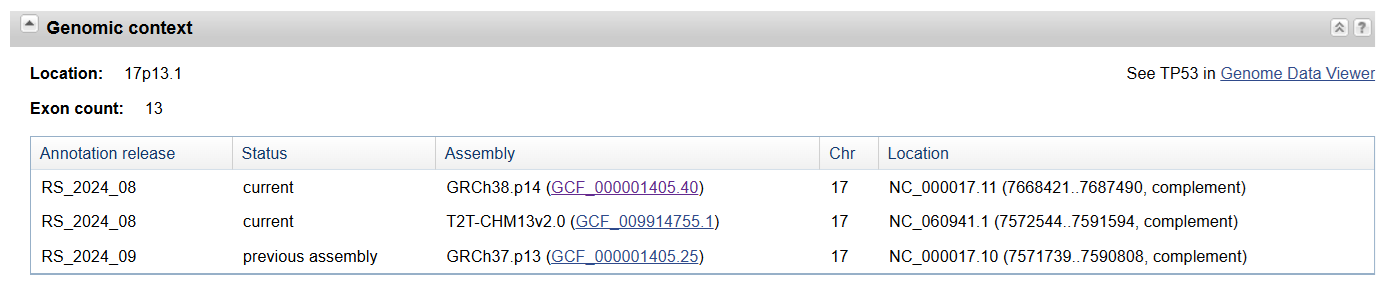

TNF location

In [9]:
tnf_df = genome_3_df[(genome_3_df['type'] == 'transcript') & (genome_3_df['gene'] == 'TNF')]
tnf_df

,seqid,gene_id,gene,transcript_id,type,start,end
1,NC_000006.12,TNF,TNF,"[""NM_000594.4""]",transcript,31575565,31578336
1107,NT_167244.2,TNF_1,TNF,"[""NM_000594.4_1""]",transcript,2909108,2910915
1116,NT_113891.3,TNF_2,TNF,"[""NM_000594.4_2""]",transcript,3052852,3055623
1128,NT_167245.2,TNF_3,TNF,"[""NM_000594.4_3""]",transcript,2823298,2826069
1140,NT_167246.2,TNF_4,TNF,"[""NM_000594.4_4""]",transcript,2880606,2883377
1152,NT_167247.2,TNF_5,TNF,"[""NM_000594.4_5""]",transcript,2917463,2920234
1164,NT_167248.2,TNF_6,TNF,"[""NM_000594.4_6""]",transcript,2831384,2834157
1176,NT_167249.2,TNF_7,TNF,"[""NM_000594.4_7""]",transcript,2874845,2877616


According to the [NCBI report on TNF gene](https://www.ncbi.nlm.nih.gov/gene/7124), the location of the TNF gene in GRCh38.p14 is **31575565..31578336**. Not all the query results of TNF gene `start` and `end` columns match this reported location. However, one row with a `gene_id` of `"TNF"` and `transcript_id` of `"NM_000594.4"`, exactly matches the reported location. Looking at the `seqid`, the rows that does not match the reported location might be in a different sequence.

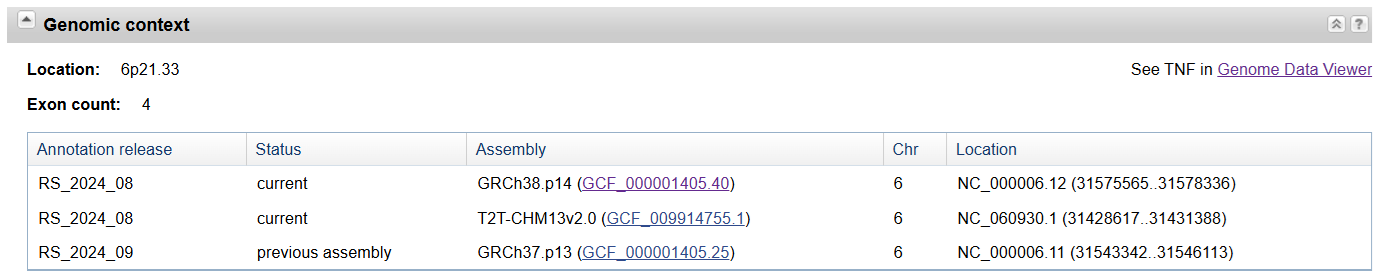

EGFR location

In [10]:
egfr_df = genome_3_df[(genome_3_df['type'] == 'transcript') & (genome_3_df['gene'] == 'EGFR')]
egfr_df

,seqid,gene_id,gene,transcript_id,type,start,end
13,NC_000007.14,EGFR,EGFR,"[""NM_005228.5""]",transcript,55019017,55211628
72,NC_000007.14,EGFR,EGFR,"[""NM_001346899.2""]",transcript,55019017,55211628
129,NC_000007.14,EGFR,EGFR,"[""NM_001346941.2""]",transcript,55019017,55211628
176,NC_000007.14,EGFR,EGFR,"[""NM_001346898.2""]",transcript,55019017,55203076
233,NC_000007.14,EGFR,EGFR,"[""NM_001346897.2""]",transcript,55019017,55203076
288,NC_000007.14,EGFR,EGFR,"[""NM_201284.2""]",transcript,55019017,55171037
323,NC_000007.14,EGFR,EGFR,"[""NM_201282.2""]",transcript,55019017,55168635
358,NC_000007.14,EGFR,EGFR,"[""NM_201283.2""]",transcript,55019017,55156939
381,NC_000007.14,EGFR,EGFR,"[""XM_047419953.1""]",transcript,55080469,55211628
439,NC_000007.14,EGFR,EGFR,"[""XM_047419952.1""]",transcript,55095532,55211628


According to the [NCBI report on EGFR gene](https://www.ncbi.nlm.nih.gov/gene/1956), the location of the EGFR gene in GRCh38.p14 is **55019017..55211628**. The query results of EGFR gene `start` and `end` columns are within the bounds of the reported location.

### In which human tissues is the gene known to be expressed ?

### TP53

![TP53](https://i.ibb.co/wh7Z2Z3d/image.png)

### TNF
![TNF Expression](https://i.ibb.co/cSzq3QZy/image.png)

### EGFR
![EGFR RNA Expression](https://i.ibb.co/jv5nhjrB/image.png)

### How many gene isoforms (alternatively spliced mRNAs) are known for each gene?



TP53 Isoforms

In [142]:
tp53_df['transcript_id'].nunique()

26

TNF Isoforms

In [143]:
tnf_df['transcript_id'].nunique()

8

EGFR Isoforms

In [144]:
egfr_df['transcript_id'].nunique()

11

### What is the average length of exons and average length of introns, across all isoforms?

In [259]:
genome_3_df['length'] = genome_3_df['end'] - genome_3_df['start']
exons_df = genome_3_df[(genome_3_df['type'] == 'exon')][['gene','transcript_id', 'length']]
exons_mean_df = exons_df.groupby(['gene','transcript_id']).mean('length')
introns_df = genome_3_df[(genome_3_df['type'] == 'exon')][['gene','transcript_id', 'start', 'end']]
introns_df = introns_df.sort_values(['gene','transcript_id', 'start', 'end'])
introns_df = introns_df.groupby(['gene','transcript_id']).agg(list)

In [264]:
def get_intron_mean(gene, introns_df):
    intron_mean = []
    for each in introns_df.loc[gene].itertuples():
        _, start, end = each
        start = pd.Series(start + [0])
        end = pd.Series([0] + end)
        introns = start - end
        intron_mean.append(introns[1:-1].mean())
    return pd.Series(intron_mean).mean()

TP53 Average Exon & Intron Length

In [266]:
print(f"Average Exon Length: {exons_mean_df.loc['TP53']['length'].mean():.2f}") 
print(f"Average Intron Length: {get_intron_mean('TP53', introns_df):.2f}") 

Average Exon Length: 235.31
Average Intron Length: 1167.77


TNF Average Exon & Intron Length

In [267]:
print(f"Average Exon Length: {exons_mean_df.loc['TNF']['length'].mean():.2f}") 
print(f"Average Intron Length: {get_intron_mean('TNF', introns_df):.2f}") 

Average Exon Length: 421.06
Average Intron Length: 350.67


EGFR Average Exon & Intron Length

In [268]:
print(f"Average Exon Length: {exons_mean_df.loc['EGFR']['length'].mean():.2f}")
print(f"Average Intron Length: {get_intron_mean('EGFR', introns_df):.2f}") 

Average Exon Length: 395.23
Average Intron Length: 7452.88


### How many protein isoforms are known for each gene?

### TP53

According to Khoury et. al, the TP53 gene has 12 protein isoforms due to alternative splicing. These different isoforms occured through a combination of internal promoters, alternative splicing of intron 9, and alternative translation initiation. 

Reference: Khoury MP, Bourdon JC. p53 Isoforms: An Intracellular Microprocessor? Genes Cancer. 2011 Apr;2(4):453-65. doi: 10.1177/1947601911408893. PMID: 21779513; PMCID: PMC3135639.

### TNF

According to Dyer et. al, the TNF gene has 2 transcript splice variants. However, only the full‐length transcript encodes the pro‐TNF cytokine, which is then proteolytically cleaved to its soluble form.

Reference: 
Dyer, S. C., Austine-Orimoloye, O., Azov, A. G., Barba, M., Barnes, I., Barrera-Enriquez, V. P., Becker, A., Bennett, R., Beracochea, M., Berry, A., Bhai, J., Bhurji, S. K., Boddu, S., Branco Lins, P. R., Brooks, L., Budhanuru Ramaraju, S., Campbell, L. I., Carbajo Martinez, M., Charkhchi, M., … Yates, A. D. (2025). Ensembl 2025. Nucleic Acids Research, 53(D1), D948–D957. https://doi.org/10.1093/nar/gkae1071

### EGFR

UniProt lists 4 distinct EGFR isoforms. Similar to the other genes, these are produced through alternative splicing and includes a full-length receptor and three truncated, extracellular‐domain-only variants.

Reference: The UniProt Consortium , UniProt: the Universal Protein Knowledgebase in 2025, Nucleic Acids Research, Volume 53, Issue D1, 6 January 2025, Pages D609–D617, https://doi.org/10.1093/nar/gkae1010

### What functions of the genes/proteins are known?

### TP53

TP53 is a transcription factor which regulates the cell during interphase. It is responsible for tasks suck ash cell cycle arrest, DNA repair, senescence, or apoptosis upon binding to specific DNA sequences in response to various stimuli which signals DNA damage. Outside of its primary role as a tumor suppressor, it also influences metabolism, autophagy, ferroptosis and aging processes.

### TNF
The TNF gene is mainly produced by macrophages which binds to TNFRSF1A and TNFRSF1A to activate various pathways responsible for chronic inflammatory responses. Furthermore, other isoforms of TNF such as tmTNF can also engage in reverse signaling, modulating apoptosis, cell survival, and cytokine production in various immune cell types. Finally, it is also a pyrogen, inducing fever via hypothalamic prostaglandin synthesis, and contributes to the pathology of autoimmune diseases, sepsis, and insulin resistance.

### EGFR
EGFR binds ligands such as epidermal growth factor and transforming growth factor-$\alpha$ which is essential for normal embryonic development, wound healing, and maintenance of epithelial tissue integrity. Aberrations in EGFR expression or activation are implicated in various cancers (e.g., lung, glioblastoma, head and neck), making EGFR a major therapeutic target in oncology.